<a href="https://colab.research.google.com/github/Sanjid9633/FMMLlab/blob/main/module_1_lab_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [16]:
import copy
import numpy as np
import matplotlib.pyplot as plt
from keras.datasets import mnist
rng = np.random.default_rng(seed=42)
from sklearn.utils.extmath import cartesian
from skimage.transform import rotate, AffineTransform, warp
import math

(train_X, train_y), (test_X, test_y) = mnist.load_data()
train_X = train_X/255
test_X = test_X/255

train_X = train_X[::1200,:,:].copy()
train_y = train_y[::1200].copy()

def NN1(traindata, trainlabel, query):
  diff  = traindata - query
  sq = diff*diff
  dist = sq.sum(1)
  label = trainlabel[np.argmin(dist)]
  return label

def NN(traindata, trainlabel, testdata):
  traindata = traindata.reshape(-1, 28*28)
  testdata = testdata.reshape(-1,28*28)
  predlabel = np.array([NN1(traindata, trainlabel, i) for i in testdata])
  return predlabel

def Accuracy(gtlabel, predlabel):
  assert len(gtlabel)==len(predlabel)
  correct = (gtlabel==predlabel).sum()
  return correct/len(gtlabel)

testpred = NN(train_X, train_y, test_X)
print('Baseline accuracy without augmentation is ', Accuracy(test_y, testpred))

def augRotate(sample, angleconstraint):
  if angleconstraint==0:
    return sample
  if len(sample.shape)==2:
    sample = np.expand_dims(sample, 0)
  angle = rng.random(len(sample))
  angle = (angle-0.5)*angleconstraint
  nsample = sample.copy()
  for ii in range(len(sample)):
    nsample[ii] = rotate(sample[ii], angle[ii])
  return np.squeeze(nsample)



Baseline accuracy without augmentation is  0.6472


Implimenting the augmentation processes

1. rotation


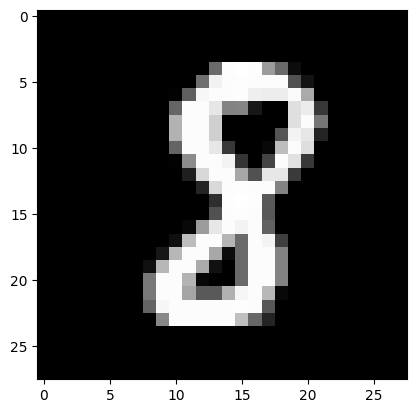

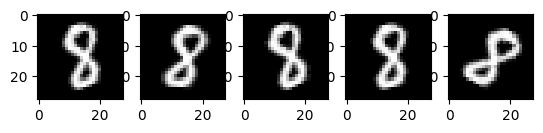

In [17]:
sample = train_X[20]
angleconstraint = 70
plt.imshow(sample, cmap='gray')
plt.show()
plt.subplot(1,5,1)
plt.imshow(augRotate(sample, angleconstraint), cmap='gray')
plt.subplot(1,5,2)
plt.imshow(augRotate(sample, angleconstraint), cmap='gray')
plt.subplot(1,5,3)
plt.imshow(augRotate(sample, angleconstraint), cmap='gray')
plt.subplot(1,5,4)
plt.imshow(augRotate(sample, angleconstraint), cmap='gray')
plt.subplot(1,5,5)
plt.imshow(augRotate(sample, angleconstraint), cmap='gray')

In [18]:
angleconstraint = 60
naugmentations = 5
augdata = train_X
auglabel = train_y
for ii in range(naugmentations):
  augdata = np.concatenate((augdata, augRotate(train_X, angleconstraint)))
  auglabel = np.concatenate((auglabel, train_y))

# check the test accuracy
testpred = NN(augdata, auglabel, test_X)
print('Accuracy after rotation augmentation is ', Accuracy(test_y, testpred))

Accuracy after rotation augmentation is  0.6633


In [19]:
angleconstraints = [0,10,15,20,25,30,35,40,45,50,55,60,65,70,75,80,85,90]
accuracies = np.zeros(len(angleconstraints), dtype=np.float)

for ii in range(len(angleconstraints)):
  augdata = train_X
  auglabel = train_y
  for jj in range(naugmentations):
    augdata = np.concatenate((augdata, augRotate(train_X, angleconstraints[ii])))
    auglabel = np.concatenate((auglabel, train_y))


  testpred = NN(augdata, auglabel, test_X)
  accuracies[ii] = Accuracy(test_y, testpred)
  print('Accuracy after rotation augmentation constrained by ',angleconstraints[ii], ' is ', accuracies[ii], flush=True)

<ipython-input-19-3c0d12bd3b15>:2: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  accuracies = np.zeros(len(angleconstraints), dtype=np.float) # we will save the values here


Accuracy after rotation augmentation constrained by  0  is  0.6472
Accuracy after rotation augmentation constrained by  10  is  0.6745
Accuracy after rotation augmentation constrained by  15  is  0.6674
Accuracy after rotation augmentation constrained by  20  is  0.6706
Accuracy after rotation augmentation constrained by  25  is  0.6791
Accuracy after rotation augmentation constrained by  30  is  0.6699
Accuracy after rotation augmentation constrained by  35  is  0.6804
Accuracy after rotation augmentation constrained by  40  is  0.6673
Accuracy after rotation augmentation constrained by  45  is  0.6764
Accuracy after rotation augmentation constrained by  50  is  0.665
Accuracy after rotation augmentation constrained by  55  is  0.6693
Accuracy after rotation augmentation constrained by  60  is  0.6791
Accuracy after rotation augmentation constrained by  65  is  0.6451
Accuracy after rotation augmentation constrained by  70  is  0.6645
Accuracy after rotation augmentation constrained b

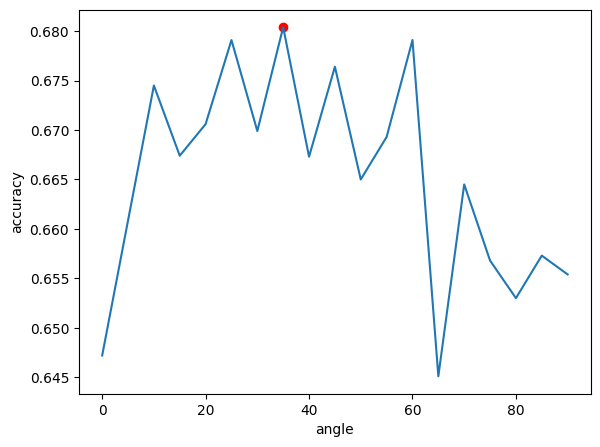

In [20]:
fig = plt.figure()
ax = fig.add_axes([0.1, 0.1, 0.8, 0.8])
ax.plot(angleconstraints, accuracies)
ax.set_xlabel('angle')
ax.set_ylabel('accuracy')
maxind = np.argmax(accuracies)
plt.scatter(angleconstraints[maxind], accuracies[maxind], c='red')

2.Shear

In [55]:
def shear(sample, amount):
  tform = AffineTransform(shear = amount)
  img = warp(sample, tform)
  row = img.sum(1).nonzero()[0]
  if len(col)>0 and len(row)>0:
    xshift = int(sample.shape[0]/2 - (row[0]+row[-1])/2)
    yshift = int(sample.shape[1]/2 - (col[0]+col[-1])/2)
    img = np.roll(img, (xshift, yshift),(0,1))
  return img

def augShear(sample, shearconstraint):
  if shearconstraint==0:
    return sample
  if len(sample.shape)==2:
    sample = np.expand_dims(sample, 0)
  amt = rng.random(len(sample))
  amt = (amt-0.5)*shearconstraint
  nsample = sample.copy()
  for ii in range(len(sample)):
    nsample[ii] = shear(sample[ii], amt[ii])
  return np.squeeze(nsample)





In [ ]:
shearconstraints = [0, 0.2,0.4,0.6,0.8,1.0,1.2,1.4,1.6,1.8,2.0]
accuracies = np.zeros(len(shearconstraints), dtype=np.float)

for ii in range(len(shearconstraints)):

  augdata = train_X
  auglabel = train_y
  for jj in range(naugmentations):
   augdata = np.concatenate((augdata, augShear(train_X, shearconstraints[ii])))
   auglabel = np.concatenate((auglabel, train_y))
  testpred = NN(augdata, auglabel, test_X)
  accuracies[ii] = Accuracy(test_y, testpred)
  print('Accuracy after shear augmentation constrained by ',shearconstraints[ii], ' is ', accuracies[ii], flush=True)

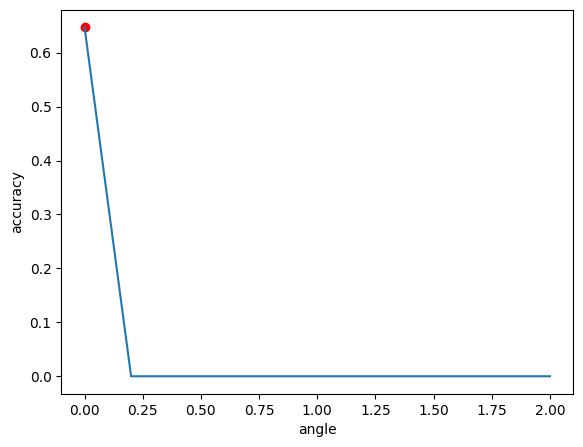

In [67]:
fig = plt.figure()
ax = fig.add_axes([0.1, 0.1, 0.8, 0.8]) # main axes
# plot the variation of accuracy
ax.plot(shearconstraints, accuracies)
ax.set_xlabel('angle')
ax.set_ylabel('accuracy')
# plot the maximum accuracy
maxind = np.argmax(accuracies)
plt.scatter(shearconstraints[maxind], accuracies[maxind], c='red')

Questions
1. What is the best value for angle constraint and shear constraint you got? How much did the accuracy improve as compared to not using augmentations?

 Answer:
 for angle constrain: at angle 35 the accuracy was 0.6804
 the accury was lifted by .0332 from not using augmentation


2.Can you increase the accuracy by increasing the number of augmentations from each sample?

 Answer: Yes, when the difference between angle constrain was decreased i.e when no of constains was increased the accuracy was increased


